## Price Analysis

#### Imports

In [21]:
import sqlite3
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

#### Set up

In [22]:
def repo_root(start=None) -> Path:
    p = Path(start or Path.cwd()).resolve()
    while p != p.parent and not (p / ".git").exists():
        p = p.parent
    return p

ROOT = repo_root()
DB = (ROOT / "events.db").resolve()
print("DB:", DB, "| exists:", DB.exists(), "| size(bytes):", DB.stat().st_size if DB.exists() else 0)

DB: /Users/student/Desktop/NWU_MLDS/400/final/ticketmaster-data-collection/events.db | exists: True | size(bytes): 3461120


#### One-time Index Creation : add indexes to speeds up reads/filters/joins

In [23]:
CREATE_INDEXES = True  # set False if already done / no write perms needed
if CREATE_INDEXES:
    with sqlite3.connect(f"file:{DB}?mode=rw", uri=True) as con_rw:  # read-write, only if file exists
        con_rw.executescript("""
        CREATE INDEX IF NOT EXISTS ix_events_event_id    ON events(event_id);
        CREATE INDEX IF NOT EXISTS ix_events_datetime    ON events(datetime);
        CREATE INDEX IF NOT EXISTS ix_prices_event_date  ON event_price_history(event_id, snapshot_date);
        CREATE INDEX IF NOT EXISTS ix_prices_currency    ON event_price_history(currency);
        """)
        con_rw.commit()

#### Open read-only for all analysis

In [28]:
con = sqlite3.connect(f"file:{DB}?mode=ro", uri=True)
q = lambda sql, params=None: pd.read_sql(sql, con, params=params)

#### Pull events (only those with a scheduled datetime)

In [29]:
events = q("""
    SELECT event_id, name, type, segment, genre, subgenre, family,
           datetime, onsale_date, offsale_date, venue_id
    FROM events
    WHERE datetime IS NOT NULL
""")
for c in ["datetime", "onsale_date", "offsale_date"]:
    if c in events.columns:
        events[c] = pd.to_datetime(events[c], errors="coerce", utc=True).dt.tz_localize(None)
print("Events with scheduled datetime:", len(events))

Events with scheduled datetime: 4410


#### Pull price history filtered in SQL (USD, non-negative, pre-event)

In [30]:
pricedf = q("""
    SELECT e.event_id, e.name, e.type, e.segment, e.genre, e.subgenre, e.family,
           e.datetime, e.onsale_date, e.offsale_date, e.venue_id,
           p.snapshot_date, p.min_price, p.max_price, p.currency
    FROM events e
    JOIN (
        SELECT event_id, snapshot_date, min_price, max_price, currency
        FROM event_price_history
        WHERE currency='USD'
          AND min_price IS NOT NULL
          AND min_price >= 0
    ) p ON p.event_id = e.event_id
    WHERE e.datetime IS NOT NULL
      AND p.snapshot_date <= e.datetime
""")
for c in ["datetime", "onsale_date", "offsale_date", "snapshot_date"]:
    pricedf[c] = pd.to_datetime(pricedf[c], errors="coerce", utc=True).dt.tz_localize(None)
print("Price records after filtering:", len(pricedf))

Price records after filtering: 1632


#### Feature engineering in Python

In [31]:
# Cheapest price (first time it occurs) per event:
cheapest = (
    pricedf.dropna(subset=["min_price"])
           .sort_values(["event_id", "min_price", "snapshot_date"])
           .groupby("event_id", as_index=False)
           .first()[["event_id", "min_price", "snapshot_date"]]
           .rename(columns={"min_price": "cheapest_price",
                            "snapshot_date": "cheapest_seen_at"})
)

feat = (
    events.merge(cheapest, on="event_id", how="left")
          .assign(
              days_before_event=lambda d: (d["datetime"] - d["cheapest_seen_at"]).dt.days,
              month=lambda d: d["datetime"].dt.month,
              weekday=lambda d: d["datetime"].dt.day_name(),
              hour=lambda d: d["datetime"].dt.hour
          )
)

print(
    f"Events total: {len(events):,} | with cheapest observed: {feat['cheapest_price'].notna().sum():,}"
)

Events total: 4,410 | with cheapest observed: 682


#### Visualizations

In [32]:
from matplotlib.ticker import StrMethodFormatter

def as_currency(ax):
    ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

##### Distribution of cheapest prices

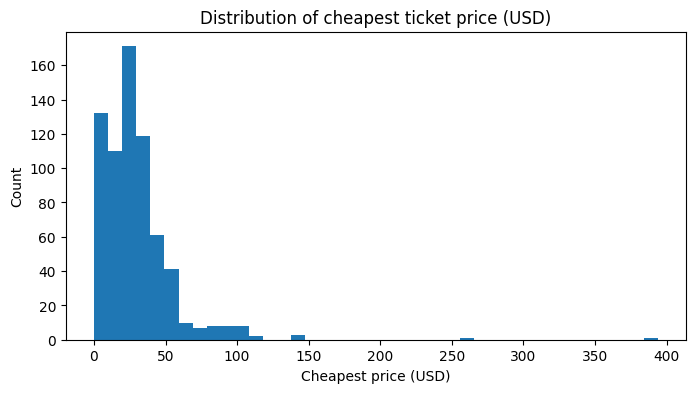

In [33]:
plt.figure(figsize=(8,4))
feat["cheapest_price"].dropna().plot(kind="hist", bins=40,
    title="Distribution of cheapest ticket price (USD)")
plt.xlabel("Cheapest price (USD)"); plt.ylabel("Count")
plt.show()

##### When is the cheapest price first observed? (lead-time histogram)

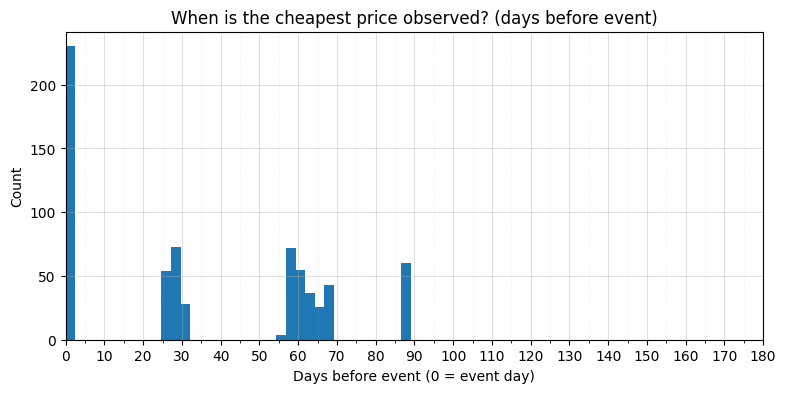

In [49]:
import matplotlib.ticker as mtick 

lead = feat["days_before_event"].dropna()
plt.figure(figsize=(9,4))
lead.clip(0, 180).plot(kind="hist", bins=36,
    title="When is the cheapest price observed? (days before event)")
plt.xlabel("Days before event (0 = event day)"); plt.ylabel("Count")

plt.xlim(0, 180)                                  # keep focus window
ax = plt.gca()
ax.xaxis.set_major_locator(mtick.MultipleLocator(10))   # ticks every 10 days
ax.xaxis.set_minor_locator(mtick.MultipleLocator(5))    # minor ticks every 5
ax.grid(True, which="major", alpha=0.4)
ax.grid(True, which="minor", alpha=0.2, linestyle=":")
plt.xticks(rotation=0)                             # keep labels horizontal
plt.show()

##### Median cheapest price by weekday/month

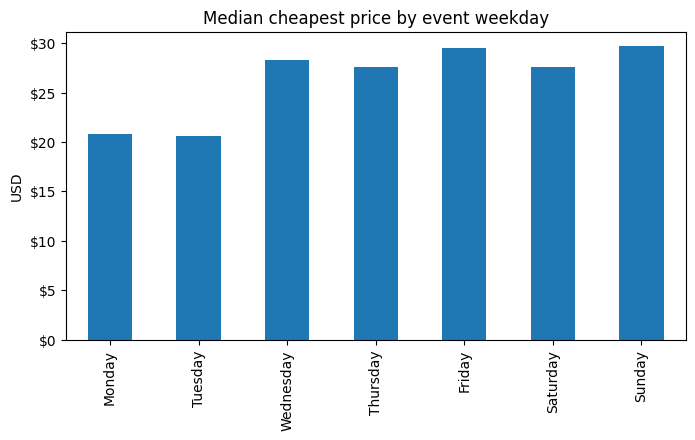

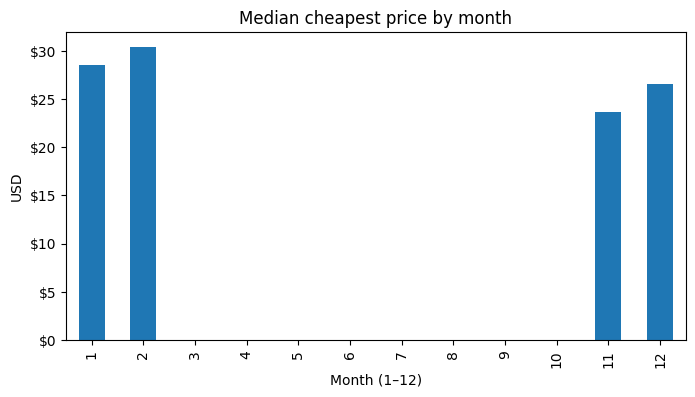

In [35]:
# Weekday
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
by_weekday = (feat.dropna(subset=["cheapest_price"])
                 .groupby("weekday")["cheapest_price"].median()
                 .reindex(weekday_order))
plt.figure(figsize=(8,4))
by_weekday.plot(kind="bar", title="Median cheapest price by event weekday")
plt.ylabel("USD"); plt.xlabel(""); as_currency(plt.gca()); plt.show()

# Month
by_month = (feat.dropna(subset=["cheapest_price"])
               .groupby("month")["cheapest_price"].median()
               .reindex(range(1,13)))
plt.figure(figsize=(8,4))
by_month.plot(kind="bar", title="Median cheapest price by month")
plt.ylabel("USD"); plt.xlabel("Month (1–12)"); as_currency(plt.gca()); plt.show()

##### Cheapest price vs lead time (scatter + rolling median)

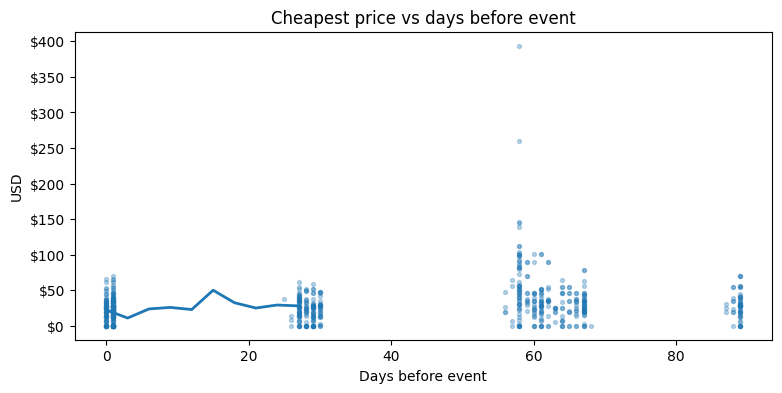

In [36]:
tmp = feat[["days_before_event", "cheapest_price"]].dropna()
plt.figure(figsize=(9,4))
plt.scatter(tmp["days_before_event"], tmp["cheapest_price"], s=8, alpha=0.3)
plt.title("Cheapest price vs days before event")
plt.xlabel("Days before event"); plt.ylabel("USD")

# rolling median across 3-day bins
grid = np.arange(0, max(1, int(tmp["days_before_event"].max()) + 1), 3)
med = (tmp.assign(bin=np.digitize(tmp["days_before_event"], grid))
          .groupby("bin")["cheapest_price"].median())
plt.plot(grid[:len(med)], med.values, linewidth=2)
as_currency(plt.gca())
plt.show()


##### Median cheapest by genre (top 10)

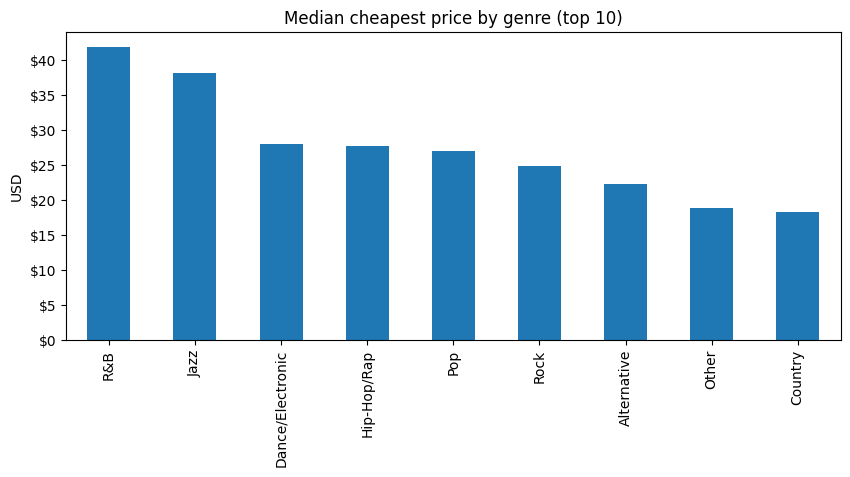

In [38]:
top_genre = feat["genre"].value_counts().head(10).index
by_genre = (feat[feat["genre"].isin(top_genre)]
              .dropna(subset=["cheapest_price"])
              .groupby("genre")["cheapest_price"].median()
              .sort_values(ascending=False))
plt.figure(figsize=(10,4))
by_genre.plot(kind="bar", title="Median cheapest price by genre (top 10)")
plt.ylabel("USD"); plt.xlabel(""); as_currency(plt.gca()); plt.show()

##### Median cheapest price by state

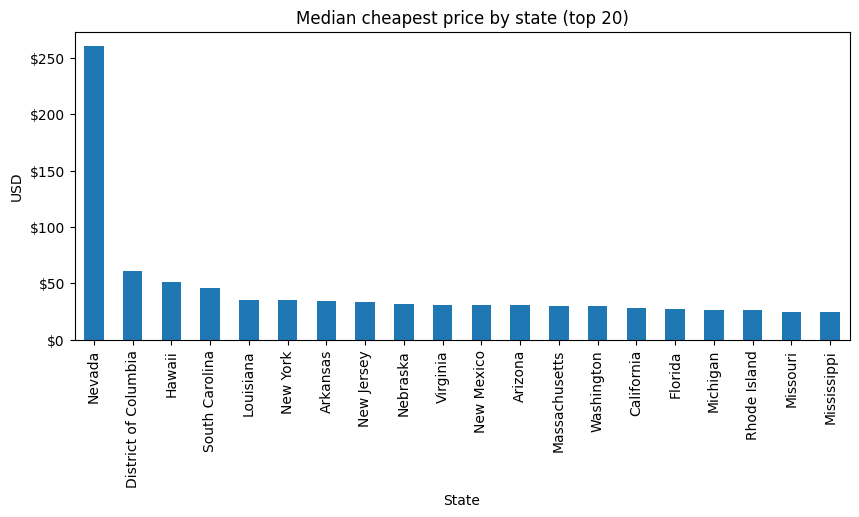

In [42]:
venues = q("SELECT venue_id, venue_name, city, state, country FROM venues;")
feat_geo = feat.merge(venues, on="venue_id", how="left")
by_state = (feat_geo.dropna(subset=["cheapest_price", "state"])
                    .groupby("state")["cheapest_price"].median()
                    .sort_values(ascending=False))
plt.figure(figsize=(10,4))
by_state.head(20).plot(kind="bar", title="Median cheapest price by state (top 20)")
plt.ylabel("USD"); plt.xlabel("State"); as_currency(plt.gca()); plt.show()

##### Deal window hit-rate: % of events whose cheapest price occurs within 5/15/30 days before the event.

In [52]:
def pct_within(days): 
    s = feat["days_before_event"].dropna()
    return float((s <= days).mean()) if len(s) else np.nan
print({
    "within_5d": pct_within(5),
    "within_15d": pct_within(15),
    "within_30d": pct_within(30),
})

{'within_5d': 0.33724340175953077, 'within_15d': 0.33724340175953077, 'within_30d': 0.5645161290322581}


##### Average price trajectory (not just cheapest): Plot the mean min_price across all events for each “days_before_event” k

<Figure size 900x400 with 0 Axes>

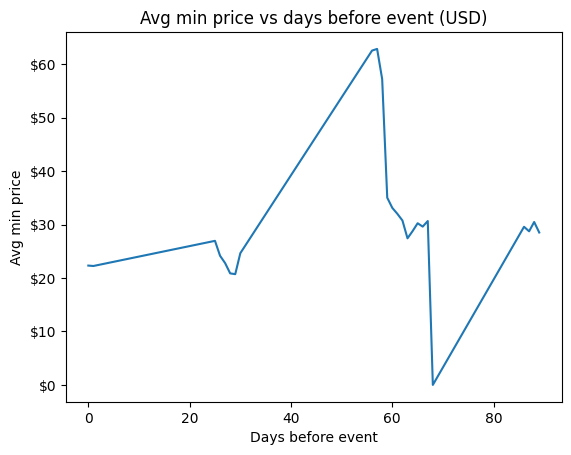

In [46]:
traj = pricedf.assign(
    days_before_event=(pricedf["datetime"] - pricedf["snapshot_date"]).dt.days
)
roll = (traj[traj["days_before_event"].between(0, 120)]
           .groupby("days_before_event")["min_price"]
           .mean().reset_index())
plt.figure(figsize=(9,4))
roll.plot(x="days_before_event", y="min_price", legend=False)
plt.title("Avg min price vs days before event (USD)")
plt.xlabel("Days before event"); plt.ylabel("Avg min price")
as_currency(plt.gca()); plt.show()

##### Price volatility per event: Number of distinct price levels observed; relate volatility to cheapest price.

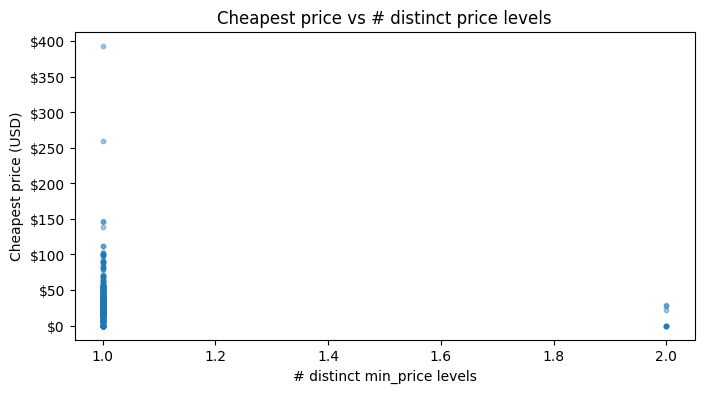

In [47]:
vol = (pricedf.sort_values(["event_id","snapshot_date"])
              .groupby("event_id")["min_price"].nunique()
              .rename("price_levels").reset_index())
feat2 = feat.merge(vol, on="event_id", how="left")
plt.figure(figsize=(8,4))
plt.scatter(feat2["price_levels"], feat2["cheapest_price"], s=10, alpha=0.4)
plt.title("Cheapest price vs # distinct price levels")
plt.xlabel("# distinct min_price levels"); plt.ylabel("Cheapest price (USD)")
as_currency(plt.gca()); plt.show()

##### On-sale timing vs price: Lead time from onsale_date to event and its relation to cheapest price.

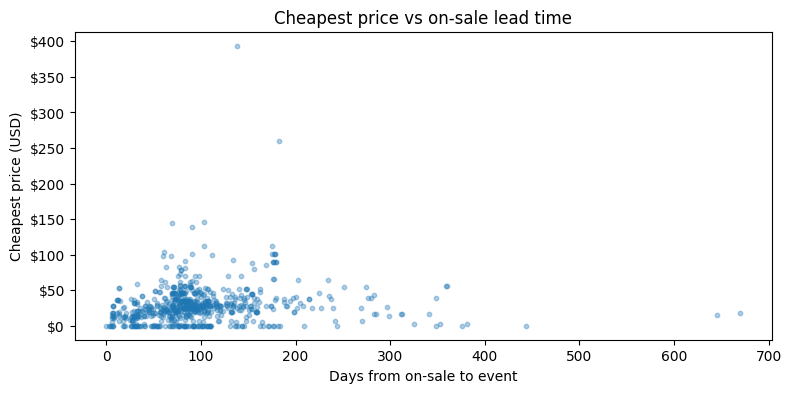

In [48]:
feat3 = feat.assign(
    onsale_lead_days=(feat["datetime"] - feat["onsale_date"]).dt.days
)
plt.figure(figsize=(9,4))
plt.scatter(feat3["onsale_lead_days"], feat3["cheapest_price"], s=10, alpha=0.35)
plt.title("Cheapest price vs on-sale lead time")
plt.xlabel("Days from on-sale to event"); plt.ylabel("Cheapest price (USD)")
as_currency(plt.gca()); plt.show()